In [19]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
import csv

In [20]:
X = pd.read_csv('/home/gregory178/Desktop/NAX project/FM_Draft_15/train_data_Draft_15.csv')

# Load y_data_pre from CSV and select relevant columns
y_data = X[['BDSPPatientID', 'annot', 'hospital']]
y = y_data['annot']


# Merge X and y based on 'BDSPPatientID'
Xy = pd.read_csv('/home/gregory178/Desktop/NAX project/FM_Draft_15/train_data_Draft_15.csv')


In [21]:
Xy.head()

,Unnamed: 0,BDSPPatientID,ContactDate,NoteFileName,Site,CT,MRI,acut sdh_pos,brain injuri_pos,brain mri_pos,...,recent sdh_neg,resolv sdh_neg,known sdh_neg,history_sdh,ICD_I62.0,ICD_S06.5,ICD_432.1,ICD_852.2or3,annot,hospital
0,1626,150193817,2015-12-01,Notes_1130052534_869813917_20151201.txt,BIDMC,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,BIDMC
1,2420,150063482,2018-01-08,Notes_1129922598_226294287_20180108.txt,BIDMC,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,BIDMC
2,2750,150716414,2013-08-01,Notes_1130575137_11785246514_20130801.txt,BIDMC,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,BIDMC
3,1134,119533582,2017-06-25,Notes_13327191775_1462051326_20170625.txt,MGB,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,MGB
4,1737,151208332,2014-08-03,Notes_1131066947_433961435_20140803.txt,BIDMC,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,BIDMC


In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
##DO I need half before starting? 


#TODO
# align X and y
# assume X has the column: BDSPPatientID
# assume y has two columns: BDSPPatientID, annotation

X = Xy.iloc[:,:-1]
y = Xy.iloc[:,-2]

# Separate data by hospital
## SWITCH TO CHANGE TRAINING AND TESTING SET ##
train_hospital = 'MGB'
test_hospital = 'BIDMC'

X_train = X[Xy['hospital'] == train_hospital]
y_train = y[Xy['hospital'] == train_hospital]

X_test = X[Xy['hospital'] == test_hospital]
y_test = y[Xy['hospital'] == test_hospital]


X_train = X_train.loc[:, "CT":"ICD_852.2or3"] ##(Help from Niels)
X_test = X_test.loc[:, "CT":"ICD_852.2or3"]

all_predictions = []
all_true_labels = []
all_row_numbers = []

# Outer loop
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
final_Cs = []
final_l1 = []
predictions = []
roc_curves = []
pr_curves = []

# Dictionary to store feature importances
feature_importances_dict = {feature: [] for feature in X.columns}

model = LogisticRegression(
    penalty='elasticnet',
    class_weight=None, random_state=2023,
    solver='saga', max_iter=10000
)

search_spaces = {
    'C': (1e-4, 1e+4, 'log-uniform'),
    'l1_ratio': (0.01, 0.99),
}
model_cv = BayesSearchCV(model,
                         search_spaces,
                         n_iter=50, scoring='roc_auc', n_jobs=15,
                         cv=5, random_state=2023)



model_cv.fit(X_train, y_train)

# Find the best hyperparameters and append them
best_hparams = model_cv.best_params_
best_C = best_hparams['C']
best_l1_ratio = best_hparams['l1_ratio']
final_Cs.append(best_C)
final_l1.append(best_l1_ratio)

model = model_cv.best_estimator_

ytr_pred = model.predict_proba(X_train)[:, 1]
yte_pred = model.predict_proba(X_test)[:, 1]

fpr, tpr, cutoffs = roc_curve(y_train, ytr_pred)  # we should use training data to determine best_cutoff
best_cutoff = cutoffs[np.argmax(tpr - fpr)]

fpr, tpr, _ = roc_curve(y_test, yte_pred)
yte_pred_bin = (yte_pred > best_cutoff).astype(int)
auc_cv.append(roc_auc_score(y_test, yte_pred))
f1_cv.append(f1_score(y_test, yte_pred_bin))
cf_cv.append(confusion_matrix(y_test, yte_pred_bin))
predictions.append(yte_pred_bin)

# Store the predictions and true labels
all_predictions.extend(yte_pred_bin)
all_true_labels.extend(y_test)
all_row_numbers.extend(y_data[y_data['hospital'] == test_hospital]['BDSPPatientID'])

# Save info for the plots
roc_curves.append((fpr, tpr, roc_auc_score(y_test, yte_pred)))
precision, recall, thresholds = precision_recall_curve(y_test, yte_pred)
pr_curves.append((recall, precision, auc(recall, precision)))
auc_pr_loop = auc(recall, precision)
auc_pr.append(auc_pr_loop)

# Extract feature importances (coefficients)
feature_importances = model.coef_[0]
for feature, importance in zip(X_train.columns, feature_importances):
    feature_importances_dict[feature].append(importance)

print("Feature importances:")
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)



Feature importances:
                     Feature  Importance
24                   sdh_pos    3.424035
3           brain injuri_pos    1.925129
68                 ICD_S06.5    1.499905
21          neurosurgeri_pos    1.321978
18          midlin shift_pos    1.217217
..                       ...         ...
32            resolv sdh_pos   -0.912839
53          neurosurgeri_neg   -1.055435
33             known sdh_pos   -1.120318
31            recent sdh_pos   -1.213532
48  intracrani hemorrhag_neg   -1.486222

[71 rows x 2 columns]


In [23]:
X_train = X_train.loc[:, "CT":"ICD_852.2or3"]
X_train.head()

,CT,MRI,acut sdh_pos,brain injuri_pos,brain mri_pos,burr hole_pos,stabl sdh_pos,craniectomi_pos,craniotomi_pos,ct head_pos,...,trauma_neg,prior sdh_neg,recent sdh_neg,resolv sdh_neg,known sdh_neg,history_sdh,ICD_I62.0,ICD_S06.5,ICD_432.1,ICD_852.2or3
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
8,0,1,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,1,1,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [24]:
print(auc_cv)
print(auc_pr)

# previous
# [0.970074464474656]
# [0.844698614731578]

#Previous Draft fourteen
# [0.9688766445069973]
# [0.8477919798092999]

#GOod
# [0.97178135792857]
# [0.8479161431621038]

[0.9679084066998064]
[0.8469494963530021]


In [25]:
feature_importances_dict

{'Unnamed: 0': [],
 'BDSPPatientID': [],
 'ContactDate': [],
 'NoteFileName': [],
 'Site': [],
 'CT': [-0.5217622495842907],
 'MRI': [0.8397207072294542],
 'acut sdh_pos': [0.8666724076344062],
 'brain injuri_pos': [1.9251289051805394],
 'brain mri_pos': [-0.5661207864049032],
 'burr hole_pos': [-0.05530104840523038],
 'stabl sdh_pos': [0.8411659196223435],
 'craniectomi_pos': [-0.3475017132078654],
 'craniotomi_pos': [-0.3985057869742564],
 'ct head_pos': [0.4677464891088909],
 'drainag_pos': [0.13286319014254205],
 'evacu_pos': [0.21725802052214144],
 'head ct_pos': [0.480877083386328],
 'hematoma_pos': [0.07686071125314917],
 'chronic sdh_pos': [0.07900529803149982],
 'herniat_pos': [0.8186401127464006],
 'intracrani hemorrhag_pos': [-0.06357321865253605],
 'intraparenchym hemorrhag_pos': [-0.5214234806518566],
 'midlin shift_pos': [1.2172168061178315],
 'mva_pos': [-0.64819474308523],
 'mvc_pos': [0.5184547207534668],
 'neurosurgeri_pos': [1.3219782543331677],
 'neurosurg intervent

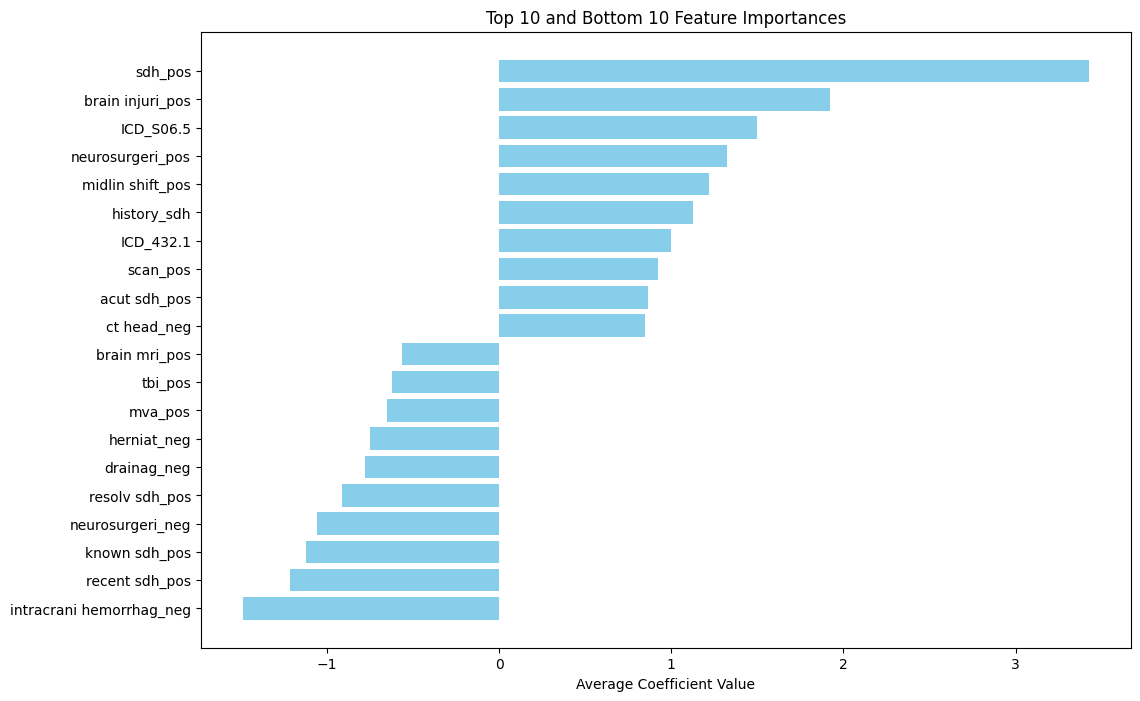

<Figure size 640x480 with 0 Axes>

In [26]:
# Save the DataFrame to a CSV file
feature_importance_df.to_csv('/home/gregory178/Desktop/NAX project/FM_Draft_15/trainMGB_testBIDMC_feat_importances_Draft_15.csv', index=False)
drop = ['BDSPPatientID','Site', 'annot', 'ContactDate', 'NoteFileName', 'Unnamed: 0']
for item in drop:
    del feature_importances_dict[item]

# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Select top 10 and bottom 10 features
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Top 10 and Bottom 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

plt.savefig('/home/gregory178/Desktop/NAX project/FM_Draft_15/trainMGB_testBIDMC_feat_importances_Draft_15.png')

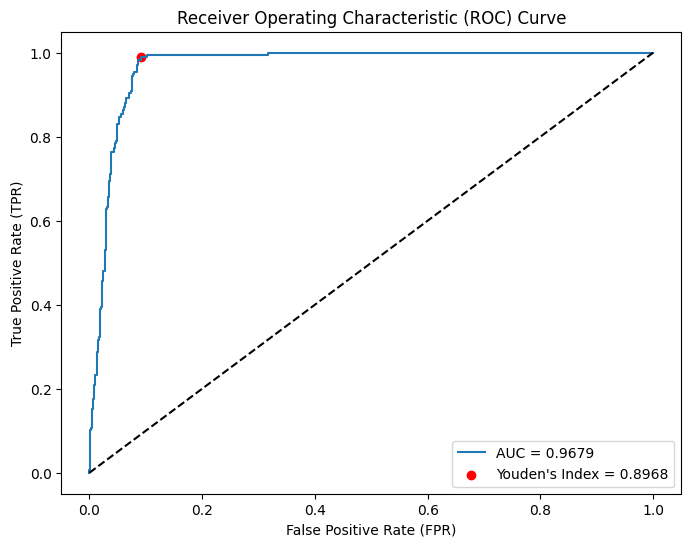

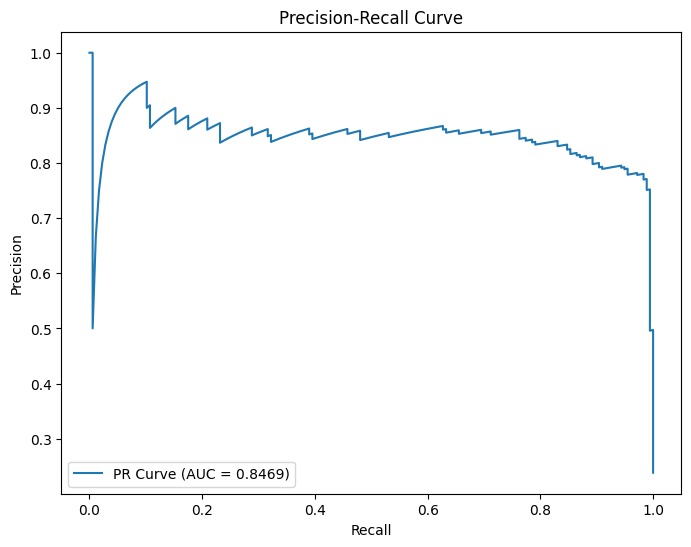

0.9679084066998064
[0.8469494963530021]
0.6159420289855072


In [27]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))

for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    youden = np.max(tpr-fpr)
    plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('/home/gregory178/Desktop/NAX project/FM_Draft_15/train_MGB_AUC_iter_Draft_15.png')#
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig('/home/gregory178/Desktop/NAX project/FM_Draft_15/train_MGB_PR_iter_Draft_15.png')#
plt.show()


# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv('/home/gregory178/Desktop/NAX project/FM_Draft_15/train_MGB_LR_iter_pred_Draft_15.csv', index=False)#

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df['C'] = final_Cs
df['l1_ratio'] = final_l1
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df_pred = pd.concat([df1]).reset_index()
df.to_csv('/home/gregory178/Desktop/NAX project/FM_Draft_15/train_MGB_LR_iter_Draft_15.csv')#

# Print final Data
print(auc_final)
print(auc_pr)
print(f1_final)